In [174]:
import numpy as np
import sklearn
import scipy
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [175]:
coordinates = [
[4.4184, 114.0932],
[4.3555,	113.9777],
[4.3976,	114.0049],
[4.3163,	114.0764],
[4.3184,	113.9932],
[4.4024,	113.9896],
[4.4142,	114.0127],
[4.4804,  114.0734],
[4.3818,	114.2034],
[4.4935,	114.1828],
[4.4932,	114.1322],]

vehicles = {
    0: {"cost_weight": 1.2,
        "capacity": 25},
    1: {"cost_weight": 1.5,
        "capacity": 30},
}

demands = [0,5,8,3,6,5,8,3,6,5,8]

In [176]:
class Ant:
  def __init__(self, graph, vehicles, start_index=0):
    super().__init__()
    # ISSUE, does vehicle order affect the output. Case 1: the assigned demands are way less that what's provided for each vehicles
    # Consider sorting vehicles based on
    self.graph = graph
    self.current_index = start_index
    self.trips = 0
    self.vehicle_capacity = [vehicles[index]['capacity'] for index in range(len(vehicles))]
    self.vehicle_load = [0 for _ in vehicles]
    self.cost_weights = [vehicles[index]['cost_weight'] for index in range(len(vehicles))]
    self.path = [[start_index,] for _ in range(len(vehicles))]
    self.to_visit = list(range(1, graph.num_nodes))
    self.total_traveled_distance = 0
    self.total_cost = 0

  def move_next(self, next_index):
    self.path[self.trips].append(next_index)
    self.total_traveled_distance +=self.graph.distances[self.current_index, next_index]
    if next_index==0:
      self.vehicle_load[self.trips] = 0
      self.trips += 1
    else:
      self.vehicle_load[self.trips] += self.graph.demands[next_index]
      self.to_visit.remove(next_index)

  def check_condition(self, next_index):
    if self.vehicle_load[self.trips]+ self.graph.demands[next_index]>= self.vehicle_capacity[self.trips]:
      return False
    return True

  def filter_next_index(self):
    filtered_next_indices = []
    for next_ind in self.to_visit:
      if self.check_condition(next_ind):
        filtered_next_indices.append(next_ind)
    return filtered_next_indices

  def select_next_index(self, to_visit):
    # get transition from current index to all other indices
    transition_prob = self.graph.pheromone[self.current_index][to_visit]
    transition_prob = transition_prob / np.sum(transition_prob)

    if np.random.random_sample()<self.graph.rho:
      next_index = to_visit[np.argmax(transition_prob)]

    else:
      next_index = np.random.choice(to_visit, p=transition_prob)
    return next_index

  def compute_solution(self):
    # get a sample solution
    # while there are still nodes to visit
    while(len(self.to_visit)>0):
      if self.trips == len(self.vehicle_capacity):
        break
      # select an index based on pheromone probabilities
      next_index = self.select_next_index(self.to_visit)

      # nodes that are excluded for current vehicle
      excluded = []

      # check constraints
      if self.check_condition(next_index):
        self.move_next(next_index)
      else:
        copy_to_visit = [n for n in self.to_visit]
        while not self.check_condition(next_index) and len(copy_to_visit)>0:

          # if we run out of nodes to visit
          next_index = self.select_next_index(copy_to_visit)
          excluded.append(next_index)
          copy_to_visit.remove(next_index)
        if not len(copy_to_visit) ==0:
          self.move_next(next_index)
        else:
          self.move_next(0)



    demands_fulfilled = 0

    for path in self.path:
      for index in path:
        demands_fulfilled += demands[index]
    return {"path": self.path, "cost": self.compute_cost(), "demands_fulfilled": demands_fulfilled}

  def compute_cost(self):
    # compute cost based on trips and vehicle cost multiplier/weights
    cost = 0
    for trip in range(self.trips):
      path = self.path[trip]
      # get total distance
      distance = sum([self.graph.distances[index-1,index] for index in range(1, len(path))])
      cost += distance*self.cost_weights[trip]
    return cost

$$P = (1-ρ)\times P+\frac{ρ}{costs}$$




In [185]:
class Graph:
  def __init__(self, coordinates, demands, vehicles, rho=0.3):
    self.coordinates = coordinates
    # pheremone dispersion factor
    self.rho = rho

    self.num_nodes = len(coordinates)
    self.demands = demands
    self.vehicles = vehicles
    self.distances = self.compute_distance_matrix()
    # self.visibility = 1/self.distances
    # self.initial_pheromone = np.ones_like(self.distances)
    self.pheromone = np.ones((self.num_nodes, self.num_nodes))


  def compute_distance_matrix(self):
    distances = np.zeros((self.num_nodes,self.num_nodes))
    for i in range(len(self.coordinates)):
      for j in range(len(self.coordinates)):
        distances[i, j] = self.calculate_distance(self.coordinates[i], self.coordinates[j])
    return distances


  @staticmethod
  def calculate_distance(a, b):
    return 100*np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)


def updatePheromone(graph, solutions, best_solution):
  # compute pheromone based on cost
  # Intuition, we want the pheromone to be lower when cost is higher
  # use pheromone += pheromone_factor/cost
  graph.pheromone = (1-graph.rho) * graph.pheromone
  solution_df = pd.DataFrame()
  solution_df = solution_df.from_dict(solutions)
  solution_df = solution_df.sort_values(by=["demands_fulfilled", "cost"], ascending=[False, True])
  top = solution_df.iloc[0].to_dict()
  if best_solution!=None:
    if best_solution["demands_fulfilled"]<top["demands_fulfilled"]:
      best_solution = solution_df[0].to_dict()
    elif best_solution["demands_fulfilled"]==top["demands_fulfilled"]:
      if best_solution["cost"]>top["cost"]:
        best_solution = top
  else:
    best_solution = top
  paths = best_solution['path']
  for path in paths:
    current_ind = 0
    for next_ind in path[1:]:
      graph.pheromone[current_ind][next_ind] += graph.rho/best_solution['cost']
      current_ind = next_ind
  return best_solution

def compute_distances(graph, paths):
  distances = []
  for path in paths:
    distance = sum([graph.distances[index-1,index] for index in range(1, len(path))])
    distances.append(distance)
  return distances


iterations = 10
num_ants = 100
best_solution = None
graph = Graph(coordinates, demands, vehicles, rho=0.1)
for i in range(iterations):
  ants = [Ant(graph, vehicles) for _ in range(num_ants)]
  solutions = list()
  for i, ant in enumerate(ants):
    solution = ant.compute_solution()
    solutions.append(solution)
  best_solution = updatePheromone(graph, solutions, best_solution)
distances = compute_distances(graph, best_solution['path'])




In [186]:
paths = best_solution["path"]
print(f'Total Distance = {sum(distances)} km')
print(f'Total Cost = RM{best_solution["cost"]}')
for i in range(0, len(vehicles)):
  print(f'Vehicle {i+1}:')
  print(f'Round Trip Distance: {distances[i]} km, Cost: RM {vehicles[i]["cost_weight"]*distances[i]}, Demand: {sum(demands[j] for j in best_solution["path"][i])}')
  print(f'')

Total Distance = 94.0360615136224 km
Total Cost = RM126.55959275823783
Vehicle 1:
Round Trip Distance: 48.31499837398595 km, Cost: RM 57.977998048783135, Demand: 24

Vehicle 2:
Round Trip Distance: 45.721063139636456 km, Cost: RM 68.58159470945469, Demand: 28



In [222]:
import itertools
edges = []
for path in paths:
  pairs = ([path[i-1], path[i]] for i in range(1,len(path)))
  edges.append(list(pairs))


In [223]:
print(edges)

[[[0, 10], [10, 9], [9, 1], [1, 3], [3, 7], [7, 0]], [[0, 6], [6, 4], [4, 8], [8, 2], [2, 0]]]


In [226]:
some = []
for lists in list(edges):
  some+=lists

In [227]:
print(some)

[[0, 10], [10, 9], [9, 1], [1, 3], [3, 7], [7, 0], [0, 6], [6, 4], [4, 8], [8, 2], [2, 0]]


In [231]:
G =  nx.DiGraph()
for edge in some:
  G.add_edge()

In [232]:
coordinates = np.array(coordinates)
positions = coordinates-coordinates[0]
path_positions = {i:positions[i] for i  in range(len(coordinates))}

AttributeError: 'Graph' object has no attribute 'get_edge'

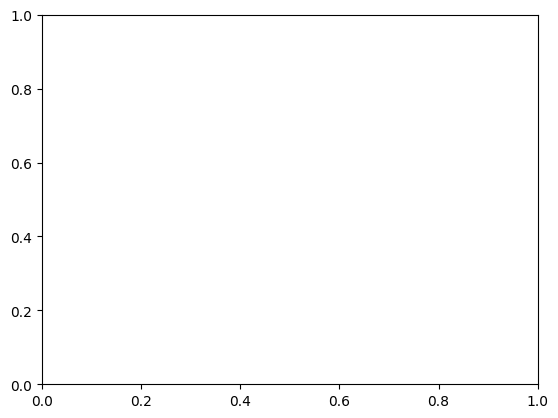

In [233]:

fig, ax = plt.subplots()

nx.draw_networkx(G, pos=path_positions, ax=ax, with_labels=True, edge_list=[G.get_edge(edge) for edge in edges[0]], edge_color="red")
nx.draw_networkx(G, pos=path_positions, ax=ax, with_labels=True, edge_list=[G.get_edge(edge) for edge in edges[1]], edge_color="blue")
ax.set_title("DAG layout in topological order")
fig.tight_layout()
plt.show()

Intuition: Treat multiple vehicles like one vehicle with multiple trips where we visit depot n times.

Constraints:

Every node should be only visited once.

Should prioritize getting high demands.
